# Setup and Config

In [3]:
#import packages
from sqlalchemy import create_engine
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Config MySQL credential in localhost
user ='root'
password ='root'
host ='localhost'
port = 3306
database = 'grocery_sales'

# Format connection string SQLAlchemy
connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}'

# Create engine connection
engine = create_engine(connection_string)

# Data Prepartion

In [6]:
# Query for Monhtly Data
monthly_data = "SELECT * FROM ct_forecast_business_main_metrics_monthly"

# Formatting query result to DataFrame
df_monthly = pd.read_sql(monthly_data,con = engine)

# Data Preview
pd.options.display.float_format = '{:,.2f}'.format #formatting the numbers to be come readable
print(df_monthly.head())

  month_key  total_order  total_revenue  total_discount
0   2018-01      1607050  81,676,812.77       48,151.30
1   2018-02      1451366  73,711,240.93       43,390.80
2   2018-03      1609190  81,830,870.36       48,299.20
3   2018-04      1556091  79,098,404.98       46,655.60


# Forecasting

## Forecasting - Monthly

### Forecasting - Monthly - Order

In [34]:
# Create series with full format of date 'YYYY-MM-01'
df_monthly['ds'] = pd.to_datetime(df_monthly['month_key'].astype(str) + '-01')

# Rename total_order to y (Required for Prophet)
df_monthly_prophet_order = df_monthly.rename(columns={'total_order': 'y'})

# Pilih kolom ds(month_key), y(total_order) , total_revenue , total_discount
df_monthly_prophet_order = df_monthly_prophet_order[['ds', 'y', 'total_revenue', 'total_discount']]

print(df_monthly_prophet_order.head())
print(df_monthly_prophet_order.info())

          ds        y  total_revenue  total_discount
0 2018-01-01  1607050  81,676,812.77       48,151.30
1 2018-02-01  1451366  73,711,240.93       43,390.80
2 2018-03-01  1609190  81,830,870.36       48,299.20
3 2018-04-01  1556091  79,098,404.98       46,655.60
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              4 non-null      datetime64[ns]
 1   y               4 non-null      int64         
 2   total_revenue   4 non-null      float64       
 3   total_discount  4 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 260.0 bytes
None


18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_6060\35908192.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_monthly_order['total_discount'].fillna(avg_discount, inplace=True)


           ds         yhat   yhat_lower   yhat_upper
7  2018-08-01 1,554,757.43 1,547,813.60 1,561,033.73
8  2018-09-01 1,554,675.85 1,544,857.51 1,563,786.50
9  2018-10-01 1,554,596.90 1,541,456.56 1,566,898.91
10 2018-11-01 1,554,515.32 1,537,469.00 1,569,887.82
11 2018-12-01 1,554,436.37 1,533,034.30 1,574,103.44


C:\Users\yusuf\AppData\Local\Temp\ipykernel_6060\35908192.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


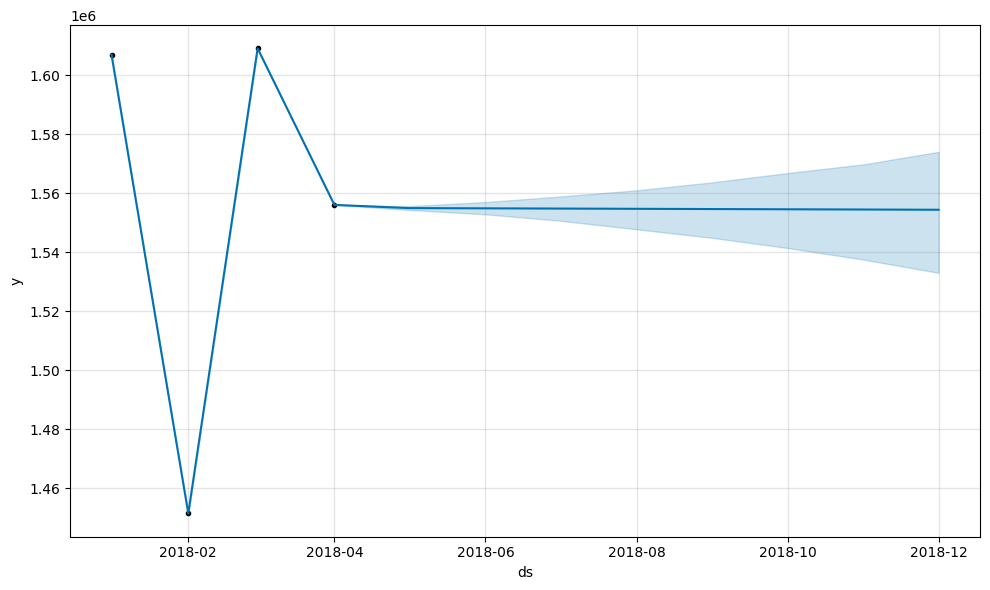

In [35]:
# create Prophet's Model
m_monthly_order = Prophet()

# Calculate the period to perform forecasting up to end of year
last_date = pd.to_datetime(df_monthly_prophet_order['ds'].max())
end_of_year = pd.Timestamp(year=last_date.year,month=12,day=31)
forecast_months = (end_of_year.year - last_date.year) * 12 + (end_of_year.month - last_date.month)

# Add variable discount as additional regressor
m_monthly_order.add_regressor('total_discount')

# Fit model to the data
m_monthly_order.fit(df_monthly_prophet_order)

# Create a dataframe for predicted period in future (e.g 90 day onwards)
future_monthly_order = m_monthly_order.make_future_dataframe(periods= forecast_months, freq='MS')

# Merge historical additional regressor (discount amount) from training to future dataframe based on 'ds'
df_monthly_prophet_order['ds'] = pd.to_datetime(df_monthly_prophet_order['ds'])
future_monthly_order['ds'] = pd.to_datetime(future_monthly_order['ds'])

future_monthly_order = future_monthly_order.merge(
    df_monthly_prophet_order[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# In the future data, the data without discount data will be filled as 0
avg_discount = df_monthly_prophet_order['total_discount'].mean()
future_monthly_order['total_discount'].fillna(avg_discount, inplace=True)

# Forecasting
future_monthly_order = m_monthly_order.predict(future_monthly_order)

# Show the prediction result for few last rows
print(future_monthly_order[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualize the predicted result
fig = m_monthly_order.plot(future_monthly_order)
fig.show()



### Forecasting - Monthly - Order Evaluation Model

In [37]:
# Parse data to have same data type
df_monthly_prophet_order['ds'] = pd.to_datetime(df_monthly_prophet_order['ds'])
future_monthly_order['ds'] = pd.to_datetime(future_monthly_order['ds'])

# Merge data origin with prediction based on data granurality key
df_merged_monthly_order = df_monthly_prophet_order.merge(future_monthly_order[['ds','yhat']], on='ds', how='left')

# Only data from origin and prediction that will be included (excluding data for future)
df_monthly_order_eval = df_merged_monthly_order[df_merged_monthly_order['yhat'].notnull()]

# Calculate MAE
mae_monthly_order = mean_absolute_error(df_monthly_order_eval['y'], df_monthly_order_eval['yhat'])
print(f'MAE: {mae_monthly_order:.2f}')

# Calculate MAPE
mape_monthly_revenue = np.mean(np.abs((df_monthly_order_eval['y'] - df_monthly_order_eval['yhat']) / df_monthly_order_eval['y'])) * 100
print(f'MAPE: {mape_monthly_revenue:.2f}%')


MAE: 0.45
MAPE: 0.00%


### Forecasting - Monthly - Revenue

In [38]:
# Create series with full format of date 'YYYY-MM-01'
df_monthly['ds'] = pd.to_datetime(df_monthly['month_key'].astype(str) + '-01')

# Rename total_order to y (Required for Prophet)
df_monthly_prophet_revenue = df_monthly.rename(columns={'total_revenue': 'y'})

# Pilih kolom ds(month_key), y(total_order) , total_revenue , total_discount
df_monthly_prophet_revenue = df_monthly_prophet_revenue[['ds', 'total_order', 'y', 'total_discount']]

print(df_monthly_prophet_revenue.head())
print(df_monthly_prophet_revenue.info())

          ds  total_order             y  total_discount
0 2018-01-01      1607050 81,676,812.77       48,151.30
1 2018-02-01      1451366 73,711,240.93       43,390.80
2 2018-03-01      1609190 81,830,870.36       48,299.20
3 2018-04-01      1556091 79,098,404.98       46,655.60
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              4 non-null      datetime64[ns]
 1   total_order     4 non-null      int64         
 2   y               4 non-null      float64       
 3   total_discount  4 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 260.0 bytes
None


18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_6060\1808755302.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_monthly_revenue['total_discount'].fillna(avg_discount, inplace=True)


           ds         yhat   yhat_lower   yhat_upper
7  2018-08-01 1,554,757.43 1,549,027.84 1,560,562.83
8  2018-09-01 1,554,675.85 1,546,785.82 1,563,411.78
9  2018-10-01 1,554,596.90 1,543,630.72 1,566,047.25
10 2018-11-01 1,554,515.32 1,540,086.47 1,569,082.97
11 2018-12-01 1,554,436.37 1,536,070.11 1,572,094.53


C:\Users\yusuf\AppData\Local\Temp\ipykernel_6060\1808755302.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


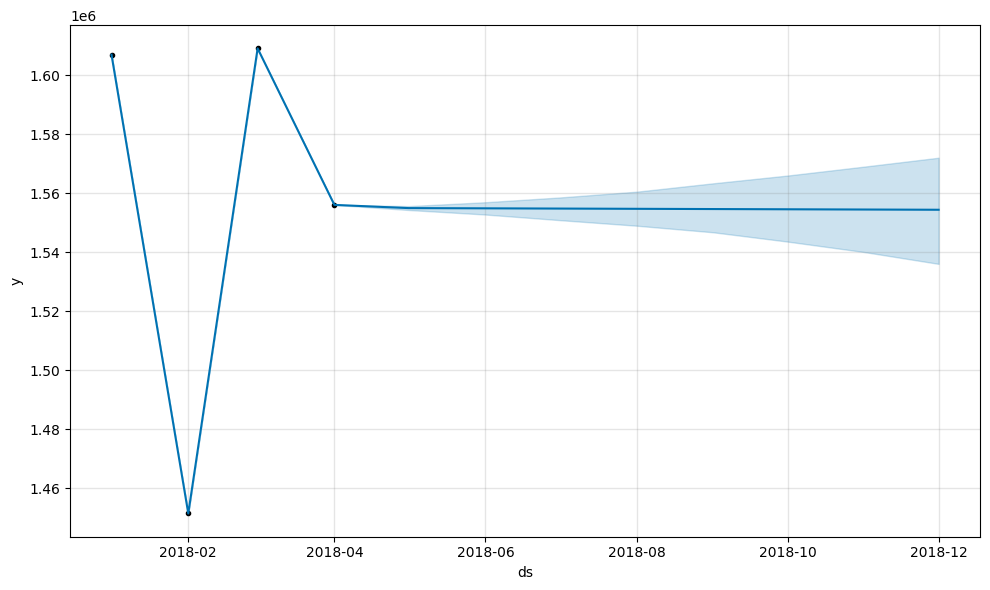

In [39]:
# create Prophet's Model
m_monthly_revenue = Prophet()

# Calculate the period to perform forecasting up to end of year
last_date = pd.to_datetime(df_monthly_prophet_order['ds'].max())
end_of_year = pd.Timestamp(year=last_date.year,month=12,day=31)
forecast_months = (end_of_year.year - last_date.year) * 12 + (end_of_year.month - last_date.month)

# Add variable discount as additional regressor
m_monthly_revenue.add_regressor('total_discount')

# Fit model to the data
m_monthly_revenue.fit(df_monthly_prophet_order)

# Create a dataframe for predicted period in future (e.g 90 day onwards)
future_monthly_revenue = m_monthly_revenue.make_future_dataframe(periods= forecast_months, freq='MS')

# Merge historical additional regressor (discount amount) from training to future dataframe based on 'ds'
df_monthly_prophet_order['ds'] = pd.to_datetime(df_monthly_prophet_order['ds'])
future_monthly_revenue['ds'] = pd.to_datetime(future_monthly_revenue['ds'])

future_monthly_revenue = future_monthly_revenue.merge(
    df_monthly_prophet_order[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# In the future data, the data without discount data will be filled as 0
avg_discount = df_monthly_prophet_order['total_discount'].mean()
future_monthly_revenue['total_discount'].fillna(avg_discount, inplace=True)

# Forecasting
future_monthly_revenue = m_monthly_revenue.predict(future_monthly_revenue)

# Show the prediction result for few last rows
print(future_monthly_revenue[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualize the predicted result
fig = m_monthly_revenue.plot(future_monthly_revenue)
fig.show()



### Forecasting - Monthly - Revenue Evaluation Model

In [42]:
# Parse data to have same data type
df_monthly_prophet_revenue['ds'] = pd.to_datetime(df_monthly_prophet_revenue['ds'])
future_monthly_revenue['ds'] = pd.to_datetime(future_monthly_revenue['ds'])

# Merge data origin with prediction based on data granurality key
df_merged_monthly_revenue = df_monthly_prophet_revenue.merge(future_monthly_revenue[['ds','yhat']], on='ds', how='left')

# Only data from origin and prediction that will be included (excluding data for future)
df_monthly_revenue_eval = df_merged_monthly_revenue[df_merged_monthly_revenue['yhat'].notnull()]

# Calculate MAE
mae_monthly_revenue = mean_absolute_error(df_monthly_revenue_eval['y'], df_monthly_revenue_eval['yhat'])
print(f'MAE Monthly Revenue: {mae_monthly_revenue:.2f}')

# Calculate MAPE
mape_monthly_revenue = np.mean(np.abs((df_monthly_revenue_eval['y'] - df_monthly_revenue_eval['yhat']) / df_monthly_revenue_eval['y'])) * 100
print(f'MAPE Monthly Revenue: {mape_monthly_revenue:.2f}%')


MAE Monthly Revenue: 77523408.46
MAPE Monthly Revenue: 98.03%


### Forecasting - Monthly - Order & Revenue

In [43]:
# Data forecasting Order
data_export_monthly_order = future_monthly_order[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]

# Data forecasting Revenue
data_export_monthly_revenue = future_monthly_revenue[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]


# Rename 'ds' to 'date_key'
data_export_monthly_order = data_export_monthly_order.rename(columns={'ds': 'period_key'})
data_export_monthly_revenue = data_export_monthly_revenue.rename(columns={'ds': 'period_key'})

# Adding prefix to each column aside 'date_key' column
order_cols = [col for col in data_export_monthly_order.columns if col != 'period_key']
data_export_monthly_order = data_export_monthly_order.rename(columns={col: 'order_' + col for col in order_cols})

revenue_cols = [col for col in data_export_monthly_revenue.columns if col != 'period_key']
data_export_monthly_revenue = data_export_monthly_revenue.rename(columns={col: 'revenue_' + col for col in revenue_cols})

# Convert date_key have datetime data_type
data_export_monthly_order['period_key'] = pd.to_datetime(data_export_monthly_order['period_key'])
data_export_monthly_revenue['period_key'] = pd.to_datetime(data_export_monthly_revenue['period_key'])

# Combined daily forecast order and forecast revenue
data_export_forecast_monthly = pd.merge(data_export_monthly_order, data_export_monthly_revenue, on='period_key', how='outer')

# Add additional column for data labeling period
data_export_forecast_monthly['forecast_granularity'] = 'forecast_monthly'
data_export_forecast_monthly['model_used'] = 'prophet'

# Check the result
print(data_export_forecast_monthly.tail())


   period_key   order_yhat  order_yhat_lower  order_yhat_upper  order_trend  \
7  2018-08-01 1,554,757.43      1,547,813.60      1,561,033.73 1,554,757.43   
8  2018-09-01 1,554,675.85      1,544,857.51      1,563,786.50 1,554,675.85   
9  2018-10-01 1,554,596.90      1,541,456.56      1,566,898.91 1,554,596.90   
10 2018-11-01 1,554,515.32      1,537,469.00      1,569,887.82 1,554,515.32   
11 2018-12-01 1,554,436.37      1,533,034.30      1,574,103.44 1,554,436.37   

    order_trend_lower  order_trend_upper  revenue_yhat  revenue_yhat_lower  \
7        1,547,813.60       1,561,033.73  1,554,757.43        1,549,027.84   
8        1,544,857.51       1,563,786.50  1,554,675.85        1,546,785.82   
9        1,541,456.56       1,566,898.91  1,554,596.90        1,543,630.72   
10       1,537,469.00       1,569,887.82  1,554,515.32        1,540,086.47   
11       1,533,034.30       1,574,103.44  1,554,436.37        1,536,070.11   

    revenue_yhat_upper  revenue_trend  revenue_trend_low

### Push Data to Database

In [45]:
# Table target
table_name = 'ct_groceries_forecast_result'

# Push data to MySQL
data_export_forecast_monthly.to_sql (
    name=table_name, 
    con=engine,
    if_exists='append',
    index=False
)
print("Data has been sucessfully push to database:", table_name)

Data has been sucessfully push to database: ct_groceries_forecast_result
